In [1]:
import cv2
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import imageio
from skimage import img_as_float32
from natsort import natsorted

path_pairs = list(zip(
    natsorted(glob('../puzzle_corners_1024x768/images-1024x768/*.png')),
    natsorted(glob('../puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

imgs_flat = imgs.reshape(-1,3) #might need to be 3 channels
msks_flat = msks.reshape(-1)


In [2]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_test_val, msks_train, msks_test_val = train_test_split(
    imgs_flat, msks_flat, test_size=0.14, random_state=42)

In [3]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=6)
kf.get_n_splits(imgs_train)

6

In [4]:
from scipy.stats import multivariate_normal

In [5]:
multivariate_normal.pdf(10, mean=2.5, cov=0.5)

2.1006826890574786e-25

In [6]:
imgs_train= imgs_train[:100]

In [7]:
imgs_train.shape

(100, 3)

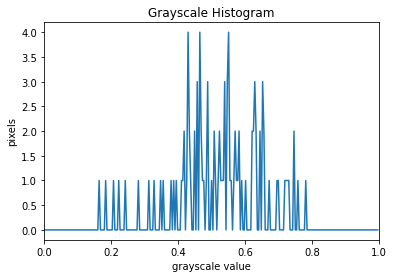

In [8]:
histogram, bin_edges = np.histogram(imgs_train[:,1], bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

In [45]:
class GMM:
    def __init__(self, K, num_features):
        self.K = K
        self.lambd = np.random.random(K)
        
        self.num_features = num_features
        self.mean = np.random.random((K, num_features))
        
        self.cov = np.random.random((K,num_features,num_features))

        self.prevent_singular = np.zeros((K,num_features,num_features))
        for k in range(K):
            self.prevent_singular[k] = 1e-6*np.eye(num_features)
            self.cov[k] *= self.cov[k].T
            self.cov[k] += 1e+3*np.eye(num_features)
    
    def expectation(self, X):
        #make it self.R
        R = []
        R_denominator = 0
        for k in range(self.K):
            #r_k_numerator = self.lambd[k]*multivariate_normal.pdf(X, mean=self.mean[k], cov=self.cov[k])
            r_k_numerator = self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)
            R_denominator += r_k_numerator
            R.append(r_k_numerator)
        
        R = np.array(R).T   
        

        #########figr 
        R = R/(R.sum(axis = 1, keepdims = 1) + 1e-6)
        
        #print(R)
        l =  np.sum(np.log(np.sum(R, axis = 1)))
        return R, l
    
    def expectation2(self, X):
        """
        rows: The number of rows
        """
        #Initialize r (Probabilirt that pixel 'j' belongs to cluster 'i')
        r = np.zeros((len(X), self.K))
        #Calculate denominator
        for c in range(self.K):
            #update r
            r[:, c] = self.lambd[c]*multivariate_normal(mean = self.mean[c], cov=self.cov[c]).pdf(X)

        #print(r / ( r.sum(axis = 1, keepdims = 1) + 1e-6))
        ll = np.sum(np.log(np.sum(r, axis = 1)))
        return r / ( r.sum(axis = 1, keepdims = 1) + 1e-6), ll
    
    
    def maximisation(self, X, R):
        
        sum_r_ik = np.sum(R, axis = 0)
        self.lambd = sum_r_ik/np.sum(R)
        
        self.mean = R.T @ X / sum_r_ik.reshape(-1,1) #lp
        
        for k in range(self.K):
            self.cov[k] = (R[:,k]*(X - self.mean[0]).T @ (X - self.mean[0])) / sum_r_ik[k]
            
            #########################################################
            self.cov = np.nan_to_num(self.cov) + self.prevent_singular
            ##--------------__#################-check
        
            
        
        
    def fit(self, X):
        for i in range(1000):
            R , l = self.expectation2(X)
            #R_1 , l = self.expectation2(X)
            
            #print(R==R_1)
            print("exp")
            self.maximisation(X,R)
            print(l)
            
        

In [46]:
imgs_train.shape

(100, 3)

In [47]:
gmm = GMM(4, 3)
gmm.fit(imgs_train)

exp
-1278.7617983000055
exp
450.11749547467525
exp
450.3523614796747
exp
454.9075366605996
exp
474.6588013426344
exp
485.5096914180632
exp
479.8395676960493
exp
478.4316818776429
exp
477.4835068926504
exp
475.98938557653616
exp
474.94732308138987
exp
474.4869275358451
exp
474.24894077701714
exp
474.06187652325883
exp
473.84349318884927
exp
473.55745191727976
exp
473.2082744359149
exp
472.8249226755796
exp
472.4421475095371
exp
472.08945425887214
exp
471.785330336055
exp
471.53618298146154
exp
471.3396206498361
exp
471.1894582667986
exp
471.07976149674374
exp
471.0068938162778
exp
470.96984914284354
exp
470.9696057682538
exp
471.0081304594197
exp
471.0873463921675
exp
471.20811630910885
exp
471.36920142572137
exp
471.56621204812444
exp
471.7907276663911
exp
472.03005467364835
exp
472.2683221554179
exp
472.48921405394805
exp
472.67945721316175
exp
472.83133847365144
exp
472.94312952175875
exp
473.017737715506
exp
473.0607046250973
exp
473.07846346475907
exp
473.0771933134564
exp
473.0622

471.6397457607372
exp
471.63974576073446
exp
471.6397457607328
exp
471.6397457607279
exp
471.63974576072667
exp
471.63974576072866
exp
471.639745760732
exp
471.6397457607304
exp
471.63974576073275
exp
471.6397457607329
exp
471.639745760735
exp
471.6397457607351
exp
471.63974576073144
exp
471.6397457607357
exp
471.6397457607354
exp
471.6397457607327
exp
471.6397457607352
exp
471.639745760734
exp
471.6397457607345
exp
471.6397457607353
exp
471.63974576073514
exp
471.63974576073537
exp
471.63974576073457
exp
471.63974576073076
exp
471.63974576072934
exp
471.6397457607307
exp
471.63974576073343
exp
471.63974576073423
exp
471.6397457607348
exp
471.63974576073366
exp
471.6397457607353
exp
471.6397457607342
exp
471.6397457607343
exp
471.63974576073355
exp
471.6397457607346
exp
471.6397457607332
exp
471.63974576073286
exp
471.63974576073394
exp
471.6397457607354
exp
471.6397457607393
exp
471.63974576073855
exp
471.6397457607375
exp
471.63974576073804
exp
471.6397457607386
exp
471.6397457607407

In [17]:
from math import floor, exp
import numpy as np
from scipy.stats import multivariate_normal

class GMM2:
    
    def __init__(self, N, min_iteration = 10, max_iteration =200):   
        """
        X: The date set
        N: The number of sources
        iteration: Number Iteration
        """
        #speccify min and maximum number of iterations to prevent over/under fitting
        self.min_iteration = min_iteration
        self.max_iteration = max_iteration
        self.N = N 
        self.cov = None
        self.mu = None
        self.lambdas = None
        #Regularization covariance
        self.reg_cov = []
        
    def e_step(self, X):
        """
        rows: The number of rows
        """
        #Initialize r (Probabilirt that pixel 'j' belongs to cluster 'i')
        r = np.zeros((len(X), self.N))
        #Calculate denominator
        for c in range(self.N):
            #update r
            r[:, c] = self.lambdas[c]*multivariate_normal(mean = self.mu[c], cov=self.cov[c]).pdf(X)
        print(r)
        print(r / ( r.sum(axis = 1, keepdims = 1) + 1e-6))
        ll = np.sum(np.log(np.sum(r, axis = 1)))
        return r / ( r.sum(axis = 1, keepdims = 1) + 1e-6), ll
    
    def m_step(self, r, X):    
        """M Step"""

        #calculate cluster weights
        c_weight = np.sum(r, axis = 0)
        #Update lambdas
        self.lambdas = c_weight / X.shape[0]
        #update mean
        weighted_sum = np.dot(r.T, X)
        self.mu = weighted_sum / c_weight.reshape(-1, 1)
        
        #update covariance
        for k in range(self.N):
            diff = (X - self.mu[k]).T
            weighted_sum = np.dot(r[:, k] * diff, diff.T)
            self.cov[k] = weighted_sum / c_weight[k]
        
        
    def run(self, X):
        _, cols  = X.shape
        #Randomly initialize mu
        #np.random.seed(100)
        self.mu = np.random.random((self.N, cols))
        #Randomly initialize cov
        self.cov = []
        for c in range(self.N):
            A = np.random.random((cols, cols))
            A *= A.T
            A += 1e+3*np.eye(cols)
            self.cov.append(A)
        self.cov = np.array(self.cov)
        #Initialzie regularization matrix
        self.reg_cov = []
        for n in range(self.N):    
            self.reg_cov.append(1e-6*np.identity(len(X[0])))
        self.reg_cov = np.array(self.reg_cov)
        #Initialize initial weigthings of each distribution
        self.lambdas = np.ones(self.N) / self.N 
        count = 0
        #Set Criteria
        ll_new = 0
        ll_old = 0
        while( self.min_iteration > count or count <= self.max_iteration ):
            #E-step
            r, ll_new = self.e_step(X)
            
            print(ll_new)
            #M-step (update paramameters)
            self.m_step(r, X)
            #Make sure the covariance matrix is not singular
            self.cov = np.nan_to_num(self.cov) + self.reg_cov
            if (abs(ll_new - ll_old) < 1e-3 and count > self.min_iteration):
                #print('broke by convergence')
                break
            ll_old = ll_new
            
            count += 1
            
            
    def predict(self,Y):
        #get prediction
        r = np.zeros((len(Y), self.N))
        #Calculate denominator
        for c in range(self.N):
            #update r
            r[:, c] = self.lambdas[c]*multivariate_normal(mean = self.mu[c], cov=self.cov[c]).pdf(Y)
        #take dot product of prediction and lambdas
        return np.array([np.dot(p, self.lambdas) for p in r])

In [18]:
gmm2 = GMM2(4)
gmm2.run(imgs_train)

[[5.01850505e-07 5.01633418e-07 5.01721292e-07 5.01856501e-07]
 [5.01849242e-07 5.01556104e-07 5.01610289e-07 5.01852600e-07]
 [5.01838081e-07 5.01648389e-07 5.01729651e-07 5.01847672e-07]
 [5.01817622e-07 5.01643749e-07 5.01734358e-07 5.01828738e-07]
 [5.01827714e-07 5.01512333e-07 5.01551695e-07 5.01830167e-07]
 [5.01798901e-07 5.01649078e-07 5.01731333e-07 5.01812653e-07]
 [5.01778320e-07 5.01632937e-07 5.01730024e-07 5.01790283e-07]
 [5.01851228e-07 5.01648027e-07 5.01722059e-07 5.01859832e-07]
 [5.01843448e-07 5.01646339e-07 5.01727540e-07 5.01851692e-07]
 [5.01815517e-07 5.01647765e-07 5.01733489e-07 5.01826592e-07]
 [5.01784864e-07 5.01635092e-07 5.01730822e-07 5.01795457e-07]
 [5.01862429e-07 5.01616332e-07 5.01702838e-07 5.01862460e-07]
 [5.01840739e-07 5.01537942e-07 5.01580336e-07 5.01843788e-07]
 [5.01830557e-07 5.01639501e-07 5.01732611e-07 5.01839699e-07]
 [5.01852872e-07 5.01647003e-07 5.01720624e-07 5.01861218e-07]
 [5.01861898e-07 5.01580230e-07 5.01652304e-07 5.018610

[[1.39232809e+001 3.41439526e+000 5.66991801e+002 1.31267112e-010]
 [3.07244958e-006 1.08936910e-004 1.91868698e-014 1.43126221e+002]
 [2.36625732e+002 6.26496227e+000 2.73807058e+003 7.00113963e-015]
 [1.06023728e+001 2.17533686e+000 7.36271035e+002 8.28020718e-013]
 [2.69762032e-011 8.07660879e-009 3.02795841e-024 1.12732300e+002]
 [4.51625597e+001 7.36737998e-001 3.61945311e+002 6.11782035e-023]
 [1.92621631e+002 7.15411495e-002 3.47591271e-001 6.05589361e-032]
 [4.55841517e+001 4.25905709e+000 1.27901962e+003 2.57301706e-015]
 [4.63201375e+002 3.90243477e+000 1.68375831e+003 7.30204426e-019]
 [4.16548048e+002 1.96966155e+000 4.43468181e+002 5.07203202e-023]
 [2.07073926e+002 1.26715244e-001 1.14902198e-004 1.87158102e-045]
 [1.60519375e+002 1.49367361e-003 6.97117607e-004 8.53366337e-044]
 [2.37861639e-009 2.21306385e-007 4.74869364e-018 3.12247125e+002]
 [1.82165441e-001 4.36003307e+000 1.17203038e+002 4.64859655e-010]
 [4.30928348e+001 3.71054102e+000 1.24291497e+003 5.12611896e-

[[1.15501402e+001 3.39969487e+000 6.23000720e+002 1.31265619e-010]
 [2.22243262e-004 1.09159436e-004 2.16706212e-016 1.43126133e+002]
 [3.75485613e+002 6.23450838e+000 2.65951742e+003 7.00112436e-015]
 [8.84557303e+000 2.15708415e+000 8.05294922e+002 8.28014357e-013]
 [1.82906544e-007 8.09226773e-009 4.31606549e-027 1.12732428e+002]
 [5.80415579e+001 7.30902220e-001 3.64544086e+002 6.11784077e-023]
 [2.05433579e+002 7.06567458e-002 1.00887886e-001 6.05589046e-032]
 [1.39071177e+002 4.24874779e+000 1.22009958e+003 2.57302416e-015]
 [7.31978689e+002 3.88645364e+000 1.29958928e+003 7.30205046e-019]
 [4.95254769e+002 1.95518416e+000 3.21531244e+002 5.07203871e-023]
 [1.96441013e+002 1.25301802e-001 6.29660950e-006 1.87160284e-045]
 [1.40604265e+002 1.49377541e-003 1.64130477e-005 8.53379766e-044]
 [6.44709508e-006 2.21813969e-007 4.12522137e-020 3.12247216e+002]
 [1.07579085e-001 4.32671111e+000 1.45874447e+002 4.64854460e-010]
 [1.38129880e+002 3.70245381e+000 1.17851560e+003 5.12613322e-